## Initialize Input Files for IPMOF (initialize_IPMOF.py)

### Initialize necessary information

1. Read FF_Parameters excel file to get force field parameters for atoms
2. Initialize force field selection, cutOff radius and grid size for energy map

### Create input files for MOF files in a given directory
1. Reaf MOF files in ".mol2" format from given directory and create a list
2. Choose the first MOF1 as the stationary (map) MOF, initialize its variables, and calculate packed coordinates
3. For all the MOFs in the list:
4. Initialize MOF2 variables for the mobile MOF
5. Calculate energy map
6. Export energy map -> .json
7. Export MOF2 structure information -> .json

In [1]:
import math
import os
os.chdir('C:\\Kutay\\IPMOF')
from energyMapFunctions import *

# Initialize force field parameters
excelFileDir = 'C:\\Users\\kutay\\iPython\\IPMOF\\FF_Parameters.xlsx'
UFF = readFFparameters(excelFileDir, 'UFF')
cutOff = 13

# Generate MOF list
fileDir = 'C:\\Kutay\\MOFs'
fileFormat = ".mol2"
MOFlist = generateMOFlist(fileDir, fileFormat)
MOFnames = []

MOFs = []
for MOFindex, mof in enumerate(MOFlist):
    MOFs.append(MOF())
    MOFs[MOFindex].dir = fileDir + '\\' + mof
    MOFs[MOFindex].file = open(MOFs[MOFindex].dir, 'r')
    MOFs[MOFindex].initialize()
    MOFs[MOFindex].initializeFF(UFF)
 
    # Calculate packing for base MOF
    packingFactor = Packing.factor(MOFs[MOFindex].UCsize, cutOff)
    MOFs[MOFindex].packingFactor = packingFactor
    translationVectors, UCvectors = Packing.vectors(packingFactor, MOFs[MOFindex].UCsize, MOFs[MOFindex].UCangle)
    MOFs[MOFindex].packedCoor = Packing.UC(translationVectors, packingFactor, UCvectors, MOFs[MOFindex].atomCoor)
    MOFs[MOFindex].edgePoints = Packing.edgePoints(UCvectors)

from tabulate import tabulate

headers = ["MOF Name", "Atoms", "UCsize", "UCangle", "Packing Factor"]
table = [[] for mof in MOFs]

for MOFindex in range(len(MOFs)):
    MOFname = MOFlist[MOFindex].split('.')[0]
    MOFnames.append(MOFname)
    MOFs[MOFindex]
    table[MOFindex].append(MOFname)
    table[MOFindex].append(MOFs[MOFindex].uniqueAtomNames)
    table[MOFindex].append(MOFs[MOFindex].UCsize)
    table[MOFindex].append(MOFs[MOFindex].UCangle)
    table[MOFindex].append(MOFs[MOFindex].packingFactor)

print(tabulate(table, headers))

MOF Name         Atoms                             UCsize                       UCangle                        Packing Factor
---------------  --------------------------------  ---------------------------  -----------------------------  ----------------
AgH6_CN2_3       ['H', 'N', 'Ag', 'C']             [6.5647, 6.5647, 11.347]     [99.8167, 99.8167, 102.913]    [5, 5, 5]
Cd2H26C17_NO2_6  ['H', 'Cd', 'N', 'C', 'O']        [12.6774, 12.6774, 18.0381]  [110.5733, 110.5733, 90.0001]  [5, 5, 3]
Cd2HC9NO8        ['O', 'Cd', 'H', 'C', 'N']        [8.3989, 8.535, 11.4883]     [89.325, 69.014, 67.269]       [5, 5, 5]
Co3H16_C9O7_2    ['Co', 'O', 'H', 'C']             [7.799, 9.212, 10.784]       [107.595, 92.877, 110.248]     [5, 5, 5]
CuNiH8C12_N2O_4  ['Cu', 'H', 'Ni', 'O', 'C', 'N']  [9.2189, 9.2189, 10.517]     [100.003, 100.003, 91.6964]    [5, 5, 5]
MgH2_CO2_2       ['Mg', 'O', 'H', 'C']             [9.8715, 18.1613, 18.2678]   [90.0, 90.0, 90.0]             [5, 3, 3]
MOF5             ['Z

In [2]:
# Creates atom list for non-repeating atoms from a list of MOF classes
atomList = getUniqueAtomList(MOFs)

# Creates atom list required in the energy map of a combination of MOFs
eMapAtomList = getEnergyMapAtomList(MOFs, atomList)

# Directory and format to export energy map and MOF structure files
exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\initializeIPMOF"
exportFormat = ".js"

for MOFindex in range(len(MOFs)-11):  
        
    # Get MOF name for base MOF from the .mol2 file list
    MOFname = MOFlist[MOFindex].split('.')[0]
    
    # Create export directory for the base MOF and create folder
    exportMOFfolder = os.path.join(exportFolder, MOFname)
    os.mkdir(exportMOFfolder)
    
    # --------------------- Calculate Energy Map -------------------
    # For each MOF energy map is calculated with an atom list that consists of all the unique atoms 
    # for a given list of MOFs
    eMap = energyMap(MOFs[MOFindex], atomList, cutOff, 1)
    
    avgEnergyLimits = calculateEnergyLimits(MOFindex, MOFs, MOFlist, eMapAtomList, eMap)
    
    for MOFindex2 in range(len(MOFs)):
        
        # Get MOF name for mobile MOF from the .mol2 file list
        MOFname2 = MOFlist[MOFindex2].split('.')[0]
        
        # Create export directory for the mobile MOF and create folder
        exportMOFfolder2 = os.path.join(exportMOFfolder, MOFname2)
        os.mkdir(exportMOFfolder2)
        
        # Create export directory for mobile MOF
        exportDir_MOF = os.path.join(exportMOFfolder2, MOFname2 + exportFormat)
        exportMOFjs(MOFs[MOFindex2], exportDir_MOF)
        print(exportDir_MOF.split("\\")[-1] + ' is exported')
             
        # Create export directory for energy map
        exportDir_eMap = os.path.join(exportMOFfolder2, MOFname + '+' + MOFname2 + '_eMap' + exportFormat)
        exportUniqueEnergyMapjs(eMap, avgEnergyLimits[MOFindex2], eMapAtomList, MOFindex2, exportDir_eMap)
        print(exportDir_eMap.split("\\")[-1] + ' is exported')
        
        # Export base MOF structure
        exportDir_baseMOF = os.path.join(exportMOFfolder2, MOFname + exportFormat)
        exportBaseMOFjs(MOFs[MOFindex], exportDir_baseMOF)

MOF Name         Atoms                               Average Energy Limit
---------------  --------------------------------  ----------------------
AgH6_CN2_3       ['N', 'H', 'Ag', 'C']                        2.85244e+12
Cd2H26C17_NO2_6  ['O', 'N', 'H', 'Cd', 'C']                   4.15211e+12
Cd2HC9NO8        ['O', 'N', 'H', 'Cd', 'C']                   4.15211e+12
Co3H16_C9O7_2    ['Co', 'O', 'H', 'C']                        2.85244e+12
CuNiH8C12_N2O_4  ['Ni', 'O', 'N', 'H', 'Cu', 'C']             3.78561e+12
MgH2_CO2_2       ['O', 'H', 'Mg', 'C']                        2.85244e+12
MOF5             ['Zn', 'O', 'H', 'C']                        2.85244e+12
NiH6_C7O3_2      ['Ni', 'O', 'H', 'C']                        2.85244e+12
YbH17C30_NO3_2   ['O', 'N', 'H', 'C', 'Yb']                   4.15211e+12
Zn2H22C27_NO_8   ['Zn', 'O', 'N', 'H', 'C']                   4.15211e+12
Zn4H12C24O13     ['Zn', 'O', 'H', 'C']                        2.85244e+12
Zn7_PO4_6        ['Zn', 'O', 'P']     

In [7]:
# Calculate Energy Map
# eMap = energyMap(MOF2, atomList, cutOff, 1)

#plotEnergyMap(eMap, 90, 0)
#plotPackedCell(MOF2.packedCoor, 90, 0)

# Create export directory for the energy map
#MOFname = MOFlist[MOFselection].split('.')[0]
#MOFname = 'MOFX'
#exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\multipleMOF"
#exportFormat = ".js"
#exportDir_eMap = os.path.join(exportFolder, MOFname + '_eMap' + exportFormat)
#exportDir_MOF = os.path.join(exportFolder, MOFname + exportFormat)
#print(exportDir_eMap)
#print(exportDir_MOF)

#eMapDir = "C:\\Users\\kutay\\iPython\\IPMOF\\eMap.js"
#exportEnergyMapjs(eMap, atomList, exportDir_eMap)

#MOFexportDir = "C:\\Users\\kutay\\iPython\\IPMOF\\MOF.js"
#exportMOFjs(MOF2, exportDir_MOF)

len(MOFs[6].atomCoor)

424

In [65]:
def findREFcodes(MOFnames):
    import os 

    cifDirectory = "C:\\Users\\kutay\\Desktop\\final_cifs"
    cifList = os.listdir(cifDirectory)
    os.chdir(cifDirectory)

    MOFformula = []
    for cifIndex, cifDir in enumerate(cifList):
        cifFile = open(cifDir, 'r')
        cifFile.readline()
        formulaLine = cifFile.readline()
        formula = formulaLine.split('_')[-1]
        formula = formula[0:len(formula)-1]
        MOFformula.append(formula)
        cifFile.close()
        cifList[cifIndex] = cifList[cifIndex].split('_')[0]

    REFcodes = [[] for i in range(len(MOFnames))]
    for cifIndex, formula in enumerate(MOFformula):
        for MOFindex, MOFname in enumerate(MOFnames):
            if formula in MOFname:
                REFcodes[MOFindex].append(cifList[cifIndex])
                
    return REFcodes

In [66]:
REFcodes = findREFcodes(MOFnames)

In [4]:
UCvectors

[[9.363, 0, 0],
 [-0.5266867638239668, 9.348174690965752, 0],
 [-0.5266867638239668, -0.5571961681359049, 9.331554130102193]]

In [15]:
MOFs[0].edgePoints

[[0, 0, 0],
 [6.5647, 0, 0],
 [-1.4670218892460913, 6.398682119504987, 0],
 [-1.9346261542700438, -2.428371802279931, 10.913965412860076],
 [5.097678110753909, 6.398682119504987, 0],
 [-3.4016480435161354, 3.970310317225056, 10.913965412860076],
 [4.630073845729957, -2.428371802279931, 8.979339258590032],
 [3.1630519564838657, 3.970310317225056, 10.913965412860076]]

In [2]:
UCedges = Packing.edgePoints(UCvectors)

In [3]:
UCedges

[[0, 0, 0],
 [9.363, 0, 0],
 [-0.5266867638239668, 9.348174690965752, 0],
 [-0.5266867638239668, -0.5571961681359049, 9.331554130102193],
 [8.836313236176032, 9.348174690965752, 0],
 [-1.0533735276479337, 8.790978522829848, 9.331554130102193],
 [8.836313236176032, -0.5571961681359049, 8.804867366278225],
 [8.309626472352065, 8.790978522829848, 9.331554130102193]]

Populating the interactive namespace from numpy and matplotlib


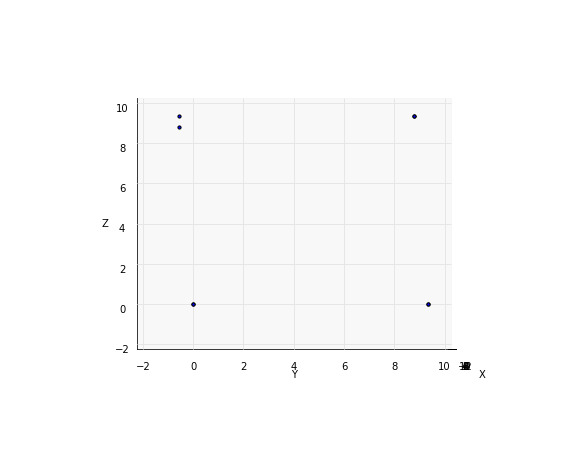

In [6]:
%pylab inline
plotXYZ(UCedges,0,0)

In [3]:
MOFs[0].atomCoor

[[0.9489, -1.7407, 9.5203],
 [2.7881, -0.7292, 5.3304],
 [0.2129, -1.9658, 9.1372],
 [2.0875, -1.04, 4.9386],
 [-0.9415, 1.7501, 4.0633],
 [-0.9964, 0.9824, 3.6802],
 [-1.4779, 4.1248, 2.6854],
 [3.3834, -1.7329, 8.1424],
 [-1.9491, 4.2543, 9.6119],
 [0.552, 5.4013, 4.0829],
 [-1.3248, 4.3508, 7.6856],
 [-0.373, 4.8038, 5.6698],
 [-2.4657, 4.0014, 7.1192],
 [-0.2169, 4.7361, 7.0122],
 [-1.4326, 4.3374, 5.0281],
 [5.5496, 0.265, 4.1549],
 [5.5041, 0.8952, 2.2286],
 [5.733, 1.9241, 0.2128],
 [5.4185, -0.295, 1.6622],
 [5.6321, 2.0611, 1.5552],
 [3.5805, -1.6412, 10.485],
 [4.174, 0.5309, 9.5399],
 [2.364, 3.0992, 5.6611],
 [3.0289, 3.2646, 4.3394],
 [4.1094, 3.8793, 5.7986],
 [3.0402, 3.3513, 5.195],
 [3.4598, 4.211, 0.2041],
 [3.8302, 6.0866, 0.3416],
 [-2.3011, 1.3405, 10.7874],
 [-2.4475, 0.5881, 10.3956],
 [1.5379, 2.4677, 9.7964],
 [1.6199, 2.498, 10.652]]

In [7]:
sortedX = sorted(MOFs[0].atomCoor, key=lambda x: x[0], reverse=True)
sortedY = sorted(MOFs[0].atomCoor, key=lambda y: y[1], reverse=True)
sortedZ = sorted(MOFs[0].atomCoor, key=lambda z: z[2], reverse=True)

In [10]:
MOFs[0].UCsize

[6.5647, 6.5647, 11.347]

In [14]:
[sortedX[0][0], sortedY[0][1], sortedZ[0][2]]

[5.733, 6.0866, 10.7874]

In [2]:
MOFs[0].edgePoints

[[0, 0, 0],
 [6.5647, 0, 0],
 [-1.4670218892460913, 6.398682119504987, 0],
 [-1.9346261542700438, -2.428371802279931, 10.913965412860076],
 [5.097678110753909, 6.398682119504987, 0],
 [-3.4016480435161354, 3.970310317225056, 10.913965412860076],
 [4.630073845729957, -2.428371802279931, 10.913965412860076],
 [3.1630519564838657, 3.970310317225056, 10.913965412860076]]

In [8]:
import math

math.ceil(-1.23)

-1

In [6]:
sortedX = sorted(MOFs[0].edgePoints, key=lambda x: x[0], reverse=True)
sortedY = sorted(MOFs[0].edgePoints, key=lambda y: y[1], reverse=True)
sortedZ = sorted(MOFs[0].edgePoints, key=lambda z: z[2], reverse=True)
eMapMax = [sortedX[0][0], sortedY[0][1], sortedZ[0][2]]
eMapMin = [sortedX[-1][0], sortedY[-1][1], sortedZ[-1][2]]
print(eMapMax)
print(eMapMin)

[6.5647, 6.398682119504987, 10.913965412860076]
[-3.4016480435161354, -2.428371802279931, 0]
